# Apply LDA to the paragraph set to identify candidate topics

## Data wrangling
### Clean up paragraph text data. Remove punctuation; lowercase the text.

In [1]:
import pandas as pd
import string

# data wrangling/cleaning
paragraphs_df = pd.read_csv('election_paragraphs.csv', delimiter = '///', engine = 'python')

# remove punctuation
paragraphs_df['Paragraph'] = paragraphs_df['Paragraph'].apply(lambda x: ''.join([c for c in x if c not in string.punctuation]))

# lowercase paragraph text
paragraphs_df = paragraphs_df.apply(lambda x: x.str.lower())

### Results

In [2]:
paragraphs_df

,Date,Paragraph
0,2000-05-01,following are excerpts from remarks prepared f...
1,2000-05-01,from what we can tell of his foreign policy go...
2,2000-05-01,governor bush dangerously fixates on the cold ...
3,2000-05-01,stuck in a cold war mindset governor bush cont...
4,2000-05-01,just this past week governor bush used his bri...
...,...,...
16497,2000-10-31,battleground states where votes for mr nader c...
16498,2000-10-31,at least five sites are dedicated to what some...
16499,2000-10-31,before the debates i really expected gore to s...
16500,2000-10-31,mr porter acknowledges that the idea has a pot...


### Vectorizing the text

In [3]:
import pandas as pd

# helper function: returns the k most frequently appearing keywords in the dataframe
def top_k(data_df, vec, k):
    X = vec.fit_transform(data_df['Paragraph'].values)
    labels = vec.get_feature_names()
    
    return pd.DataFrame(columns = labels, data = X.toarray()).sum().sort_values(ascending = False)[:k]

In [4]:
## generate feature vectors
from sklearn.feature_extraction.text import CountVectorizer 

vec = CountVectorizer(decode_error = 'ignore', stop_words = 'english')
X = vec.fit_transform(paragraphs_df['Paragraph'].values)

#### Most frequent terms over all paragraphs

In [5]:
top_terms = top_k(paragraphs_df, vec, 30)

top_terms

mr              21849
bush            11095
gore            10284
said             6844
president        3809
campaign         3464
bushs            2623
gores            2494
vice             2284
george           2103
al               2060
republican       1656
people           1583
clinton          1573
governor         1470
texas            1433
like             1397
new              1394
today            1372
tax              1274
voters           1268
plan             1181
gov              1168
years            1159
democratic       1153
did              1138
presidential     1074
time             1067
national         1025
debate           1015
dtype: int64

## Topic modeling with LDA

In [6]:
# helper function: prints the top k candidate topics
def print_topics(topic_model, vec, k):
    terms = vec.get_feature_names()
    for topic_idx, topic in enumerate(topic_model.components_):
        print("Topic #%d:" %topic_idx)
        print(" ".join([terms[i] for i in topic.argsort()[:-k - 1:-1]]) + '\n')

In [7]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

tn = 30
lda = LDA(n_components = tn)
lda.fit(X)

LatentDirichletAllocation(n_components=30)

### Candidate topics

In [8]:
print_topics(lda, vec, 10)

Topic #0:
gore mr convention said speech president al vice democratic los

Topic #1:
bush george gov mr president gore today vice texas al

Topic #2:
mr president gore vice lieberman al clinton gores senator running

Topic #3:
mr bush death texas penalty said governor case execution bushs

Topic #4:
bush mr missile defense nuclear schools vouchers states said george

Topic #5:
mr bush reagan gore ronald house years texas white said

Topic #6:
mr gore said bush voters democrats nader democratic gores party

Topic #7:
mr tax bush plan cut bushs said gores cuts gore

Topic #8:
security social mr bush gore said bushs retirement accounts campaign

Topic #9:
mr bush school education said gore trade china gun schools

Topic #10:
bush mr said gore campaign governor like people way rove

Topic #11:
mr bush said cheney policy hughes foreign military bushs mccain

Topic #12:
oil mr energy prices companies industry gore big bush said

Topic #13:
mr bush gore running republican campaign states geor

In [9]:
# transform document word matrix according to the fitted LDA model
document_topic_distribution = lda.transform(X)
document_topic_df = pd.DataFrame(document_topic_distribution)
document_topic_df['Date'] = paragraphs_df['Date']

topic_coverage = document_topic_df.groupby(['Date']).agg({i: 'sum' for i in range(30)})

### Topic coverage results

In [10]:
topic_coverage

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,
2000-05-01,0.464954,1.546252,3.903392,0.082633,1.493351,0.787444,3.120255,4.634177,6.882982,4.723434,...,2.628684,0.082633,0.718830,0.710865,1.829948,0.591993,1.634353,0.823879,6.127124,1.286616
2000-05-02,0.176824,0.580401,1.528582,0.410356,0.030056,0.328815,1.504091,0.030056,0.779905,0.442258,...,2.067568,0.441796,0.030056,0.030056,0.242295,0.303174,0.857904,2.008503,1.272403,0.750338
2000-05-03,0.154629,1.684274,1.253339,4.687028,0.199740,0.068363,1.048619,7.688125,1.920263,0.532158,...,1.989936,1.671316,0.560207,0.956739,0.773629,0.391088,0.821321,1.321329,1.837537,1.638562
2000-05-05,2.293138,2.029490,0.521492,4.483903,0.558344,1.284950,0.110026,2.625348,3.468223,3.989297,...,3.882525,2.439908,1.109815,1.349007,0.398631,1.090798,0.861467,4.252996,2.926033,3.540630
2000-05-06,1.504115,0.325833,1.137771,0.721448,0.060687,0.297022,2.886639,1.103772,0.309092,3.935233,...,0.838450,3.710971,0.430420,1.545019,0.578709,0.805134,0.831660,1.007299,3.630795,1.305705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-27,4.301061,3.995994,2.017432,3.360656,3.699580,2.730810,5.970038,3.873215,4.350276,0.725522,...,3.330636,5.684052,1.732346,3.272784,2.057249,10.052358,19.502332,4.584202,3.718142,3.553607
2000-10-28,5.142652,2.917307,5.931506,3.013286,2.889045,2.382245,6.833626,8.621501,1.987325,2.627211,...,6.533640,7.654083,2.831314,5.549705,1.516209,3.752752,10.656578,7.089324,3.716065,6.589952
2000-10-29,3.405532,2.678985,5.906741,5.564183,2.976745,7.609428,6.332210,5.316373,2.866660,3.438402,...,6.128196,8.440166,4.486560,4.150284,5.160532,11.533592,7.296875,5.491781,5.522601,7.405817


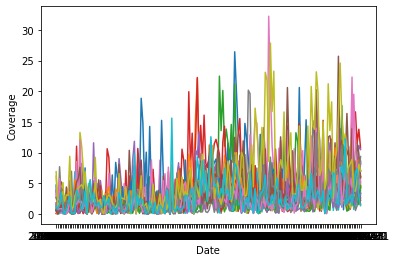

In [11]:
import matplotlib.pyplot as plt

plt.plot(topic_coverage)
plt.ylabel('Coverage')
plt.xlabel('Date')
plt.show()